In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# IMPORTING DATA
ticker1 = 'BRK-A'
ticker2 = 'BRK-B'
data = yf.download([ticker1, ticker2], start='2010-01-01')['Close']

data = data.dropna()
    
P1 = data[ticker1]
P2 = data[ticker2]
window = 750

[*********************100%***********************]  2 of 2 completed


In [32]:
#SPREAD CALCULATION
positions = []
beta_list = []
spread_roll = []
gammas = []
pvals = []
accepted_adf = 0


for t in range(window, len(P1)):

    # --- Rolling training window ---
    y = np.log(P1.iloc[t-window:t])
    x = np.log(P2.iloc[t-window:t])

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    alpha = model.params.iloc[0]
    beta = model.params.iloc[1]

    beta_list.append(beta)

    # --- Current spread (time t) ---
    s_t = np.log(P1.iloc[t]) - (alpha + beta * np.log(P2.iloc[t]))
    spread_roll.append(s_t)

    # --- Residuals for cointegration test ---
    spread_w = model.resid

        # --- ECM estimation (on training window) ---
    dy_w = y.diff().dropna()
    dx_w = x.diff().dropna()
    s_lag_w = spread_w.shift(1).dropna()

    # Align indices
    ecm_df = pd.concat([dy_w, dx_w, s_lag_w], axis=1).dropna()
    ecm_df.columns = ["dy", "dx", "s_lag"]

    X_ecm = sm.add_constant(ecm_df[["s_lag", "dx"]])
    ecm_model = sm.OLS(ecm_df["dy"], X_ecm).fit()

    gamma = ecm_model.params["s_lag"]
    gammas.append(gamma)

    # Defensive ADF
    try:
        pval = adfuller(spread_w, autolag="AIC")[1]
    except:
        positions.append(0)
        continue
    pvals.append(pval)
    # --- Cointegration filter ---
    if pval >= 0.05:
        positions.append(0)
        continue
    accepted_adf += 1

    # --- Stability condition ---
    if gamma >= 0:
        positions.append(0)
        continue

    # --- Z-score of spread ---
    mu = spread_w.mean()
    sigma = spread_w.std()

    if sigma == 0 or np.isnan(sigma):
        positions.append(0)
        continue

    z = (s_t - mu) / sigma

    # --- Trading rule ---
    entry_z = 1.0

    if abs(z) < entry_z:
        positions.append(0)
    else:
        expected_move = gamma * s_t
        positions.append(-np.sign(s_t))
print("Done")

Done


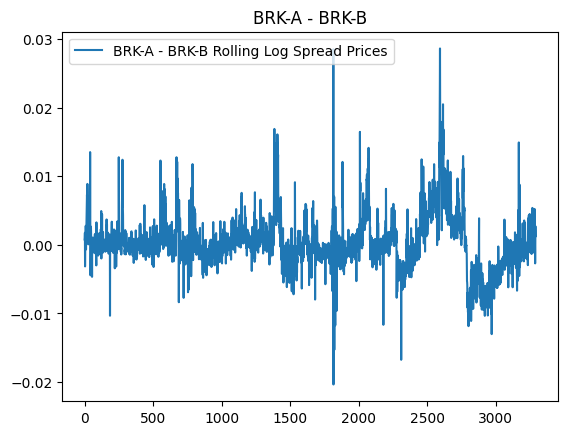

In [4]:
#VISUAL RATIONALITY CHECK
plt.plot(figsize=(12,6))
plt.plot(spread_roll, label=f"{ticker1} - {ticker2} Rolling Log Spread Prices")
plt.title(f"{ticker1} - {ticker2}")
plt.legend()
plt.show()

In [6]:
pnl = []

lp1 = np.log(P1)
lp2 = np.log(P2)

r1 = lp1.diff()
r2 = lp2.diff()

for t in range(window, len(P1) - 1):
    idx = t - window
    beta_t = beta_list[idx]
    pos_t = positions[idx]

    pnl.append(
        pos_t * (r1.iloc[t+1] - beta_t * r2.iloc[t+1])
    )

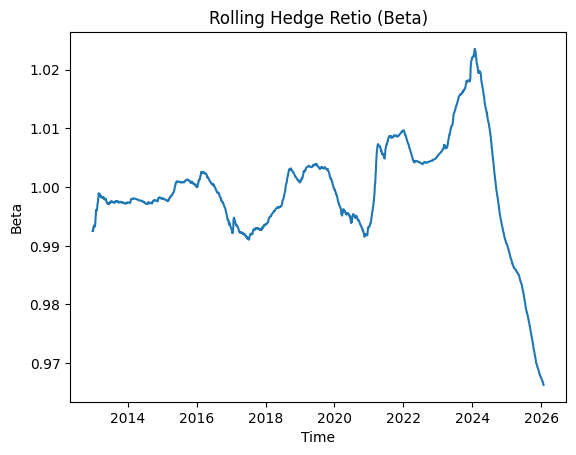

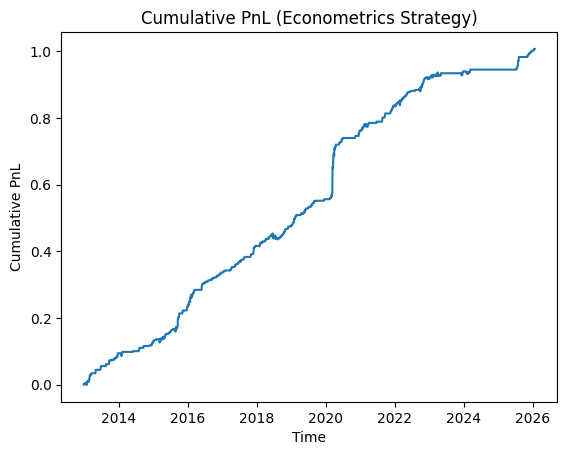

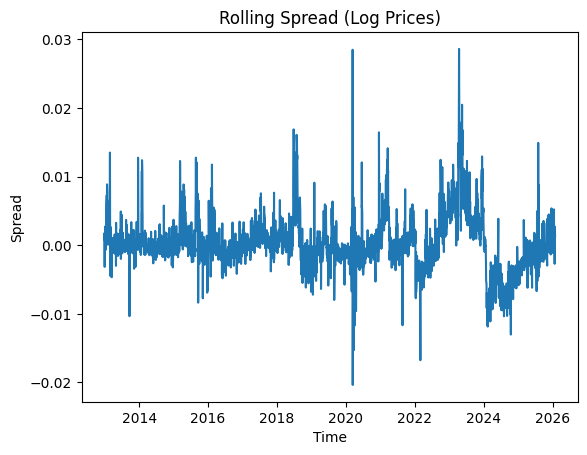

In [33]:
time_index = P1.index[window:window + len(beta_list)]

beta_series = pd.Series(beta_list, index=time_index)
spread_series = pd.Series(spread_roll, index=time_index)
pnl_series = pd.Series(pnl, index=time_index[:len(pnl)])
positions = pd.Series(positions, index=time_index)
gammas = pd.Series(gammas, index=time_index)
spread_series = pd.Series(spread_roll, index=time_index)
pvals = pd.Series(pvals, index=time_index)
z_series = (spread_series - spread_series.mean()) / spread_series.std()

cum_pnl = pnl_series.cumsum()

plt.figure()
plt.plot(beta_series)
plt.title("Rolling Hedge Retio (Beta)")
plt.xlabel("Time")
plt.ylabel("Beta")
plt.show()

plt.figure()
plt.plot(cum_pnl)
plt.title("Cumulative PnL (Econometrics Strategy)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.show()

plt.figure()
plt.plot(spread_series)
plt.title("Rolling Spread (Log Prices)")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.show()

In [20]:
print("PERFORMACE METRICS")

final_pnl = cum_pnl.iloc[-1]
mean_pnl = pnl_series.mean()
annual_pnl = mean_pnl * 252
sharpe = (mean_pnl/pnl_series.std()) * np.sqrt(252)
downside_std = pnl_series[pnl_series>0].std()
sortino = (mean_pnl/downside_std) * np.sqrt(252)
win_rate = (pnl_series >= 0).mean()
avg_win = pnl_series[pnl_series>0].mean()
avg_loss = pnl_series[pnl_series<0].mean()
profit_factor = avg_win/abs(avg_loss)
var = pnl_series.quantile(0.05)
cvar = pnl_series[pnl_series <= var].mean()

rolling_max = cum_pnl.cummax()
drawdown = cum_pnl - rolling_max
max_drawdown = min(drawdown)
drawdown_duration = (drawdown < 0).astype(int).groupby(
    (drawdown >= 0).astype(int).cumsum()
).sum().max()
volatility = pnl_series.std() * np.sqrt(252)
num_trades = (positions.diff().abs() > 0).sum()
time_in_market = (positions != 0).mean()
trade_lengths = positions.ne(positions.shift()).cumsum()
avg_holding = positions.groupby(trade_lengths).apply(
    lambda x: (x != 0).sum()
).mean()
turnover = positions.diff().abs().sum()
print("STRATEGY OVERVIEW")

print("\nPERFORMANCE METRICS:")
print(f"Final Pnl: {final_pnl * 100: .2f}%")
print(f"Mean PnL: {mean_pnl * 100: .2f}%")
print(f"Annual PnL: {annual_pnl * 100: .2f}%")
print(f"Sharpe Ratio: {sharpe: .3f}")
print(f"Downside Standard Deviation: {downside_std * 100: .2f}%")
print(f"Sortino Ratio: {sortino: .3f}")
print(f"Win Rate: {win_rate*100: .2f}%")
print(f"Profit Factor: {profit_factor: .2f}")
print(f"CVaR: {cvar*100:.2f}%")


print("\nRISK METRICS:")
print(f"Max Drawdown: {max_drawdown * 100: .2f}%")
print(f"Drawdown Duration: {drawdown_duration} Days")
print(f"Volatility: {volatility * 100: .2f}%")

print("\nTRADING BEHAVIOR METRICS:")
print(f"Number of Trades: {num_trades}")
print(f"Percent of Time in Market: {time_in_market * 100: .2f}%")
print(f"Average Holding Period: {avg_holding: .2f}")
print(f"Turnover: {turnover: .2f}")

PERFORMACE METRICS
STRATEGY OVERVIEW

PERFORMANCE METRICS:
Final Pnl:  100.69%
Mean PnL:  0.03%
Annual PnL:  7.71%
Sharpe Ratio:  2.686
Downside Standard Deviation:  0.36%
Sortino Ratio:  1.358
Win Rate:  94.80%
Profit Factor:  1.58
CVaR: -0.20%

RISK METRICS:
Max Drawdown: -1.73%
Drawdown Duration: 180 Days
Volatility:  2.87%

TRADING BEHAVIOR METRICS:
Number of Trades: 522
Percent of Time in Market:  18.30%
Average Holding Period:  1.15
Turnover:  534.00


In [36]:
adf_acceptance_rate = accepted_adf/(len(P1)-window)
trading_mask = positions != 0
avg_gamma_in_trade = gammas[trading_mask].mean()
mean_zscore_ecm = np.abs(z_series[trading_mask]).mean()
regime = (pvals < 0.05) & (gammas < 0)
regime_blocks = regime.ne(regime.shift()).cumsum()
avg_coint_regime_length = regime.groupby(regime_blocks).sum().mean()
spread_vol_coint = spread_series[regime].std()
spread_vol_no_coint = spread_series[~regime].std()

print('STRUCTURAL METRICS')
print(f'\nADF Acceptance Rate: {adf_acceptance_rate*100:.2f}%')
print(f'Average Gamma in Trade: {avg_gamma_in_trade: .4f}')
print(f'Average ECM Z-Score: {mean_zscore_ecm: .3f}')
print(f'Average Cointegration Regime Length: {avg_coint_regime_length: .1f} Days')
print(f'Spread Volatility With Cointegration: {spread_vol_coint: .2f}')
print(f'Spread Volatility Without Cointegration: {spread_vol_no_coint: .2f}')

STRUCTURAL METRICS

ADF Acceptance Rate: 84.29%
Average Gamma in Trade: -0.4078
Average ECM Z-Score:  1.414
Average Cointegration Regime Length:  84.0 Days
Spread Volatility With Cointegration:  0.00
Spread Volatility Without Cointegration:  0.01
